# Today you are a Machine Learning Engineer at the Department of New Products at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2010.02503.pdf

### So far you have seen user-product interaction data that can lead to classification of a user-product relationship as ending in purchase or no-purchase, and for clustering (categorizing) user behaviors.
### In this assignment, you have access to user-product level interactions without any insights into the user behaviors. Your goal is to classify if the "Products" will sell at least 5 pieces in a month (denoted by `Purchased?` =`1) or not. The intention is to utilize as minimum product level as possible (price and product category only) at first and then designing a more complex system that ingests more product level information.
### Labeled data is sparse, and the intention is to maximize Recall (so that no popular cosmetic is understocked). Digital overstocking is allowed since it will not cause disengagement in customers.

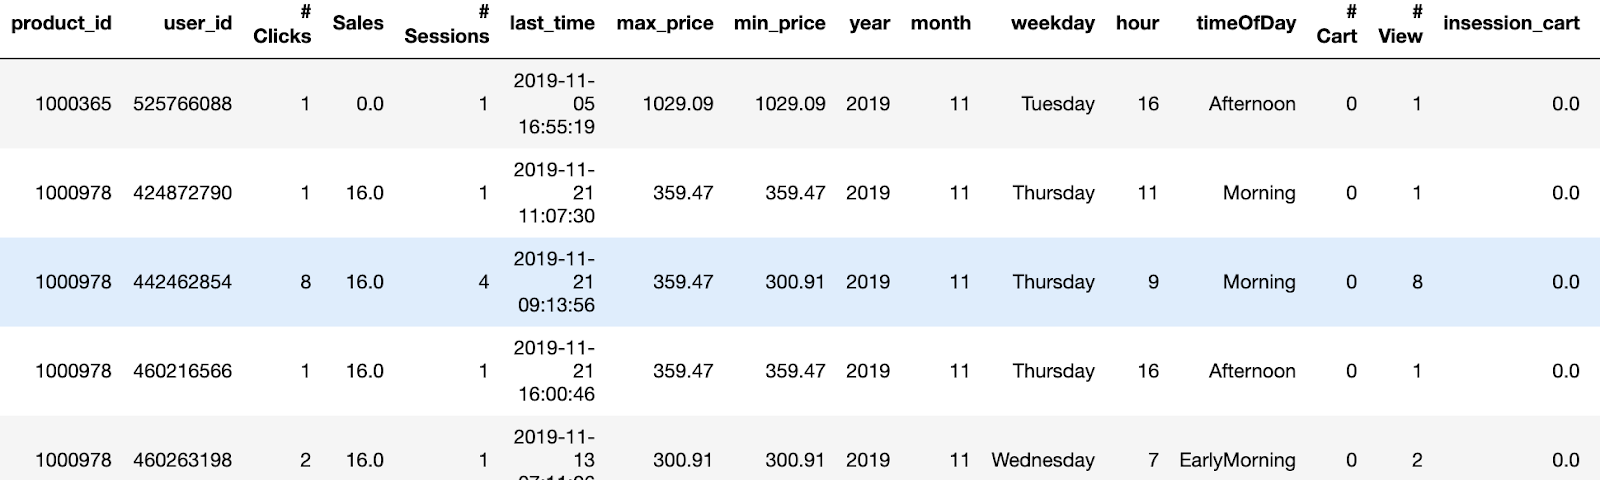

In [1]:
# The session-level data that is mined for this work is as follows:
from IPython.display import Image
Image(filename='image10.png')

## This week you are helping plan the launch of new products! You start with minimal product information and then identify what other information is helpful for the task!

## The minimal product level information available to you about the new products is their cost range and product category (cream, foundation, lipcolor, etc..).

## You have to figure out how to mine the past cosmetic sales data from last month, utilize relevant features and to make estimations as to which products will sell more (`Purchased?` = 1)

## Task 0: Getting to know the Data!

In [2]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb

In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
# Load the data from previous months (past)
Past = pd.read_csv("Past_month_products.csv")
print(Past.shape)
Past.head()

(5000, 37)


,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.00,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.25,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.00,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.25,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.25,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0


In [4]:
# Next, load the data regarding products to be launched next month
Next = pd.read_csv("Next_month_products.csv")
print(Next.shape)
Next.head()


(30091, 5)


,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


### Only the `product_id`, `maxPrice`, `minPrice`, and `Category` columns are common to both the training and test data

# Task 1: Exploratory Data Analysis (EDA) and Data Preparation
## EDA: Doing our your due diligence. Find the following:
1. Percentage of Purchased events in train data: 
2. Percentage of Purchased events in test data:
3. Are there any overlaps in product ID between train and test data?

In [6]:
### START CODE HERE ###
y_train = Past['Purchased?'].values
print(f"Percentage of Purchased in Training data = {sum(y_train) / len(y_train)}")
y_test = Next['Purchased?'].values
print(f"Percentage of Purchased in Test data = {sum(y_test) / len(y_test)}")

# Verify that every product ID in the training data appears only once
print("Every product ID in the training data appears only once: {0}".format(
      {len(np.unique(Past['product_id'])) == len(Past['product_id'])}))
# Verify that every product ID in the test data appears only once
print("Every product ID in the test data appears only once: {0}".format(
      {len(np.unique(Next['product_id'])) == len(Next['product_id'])}))
# Determine whether any product IDs appear in both the training and test data
overlap = np.intersect1d(Past['product_id'], Next['product_id'])
print(f"These product IDs are present in both the training and test data: {overlap}")
### END CODE HERE ###

Percentage of Purchased in Training data = 0.3438
Percentage of Purchased in Test data = 0.3442557575354757
Every product ID in the training data appears only once: {True}
Every product ID in the test data appears only once: {True}
These product IDs are present in both the training and test data: []


## Next, create `X_train`, `y_train`, `X_test`, and `y_test`. Remember the following: 
1. The `Purchased?` column is the target
2. `X_train` and `X_test` should contain the same features
3. `product_id` should NOT be one of those features. Can you see why?

In [41]:
### START CODE HERE ###
feature_columns = ['maxPrice', 'minPrice', 'Category']
target_column = ['Purchased?']
def return_train_test_data(df_old, df_new):
    X_train = df_old[feature_columns]
    y_train = df_old[target_column].values
    X_test  = df_new[feature_columns]
    y_test  = df_new[target_column].values
    return X_train, y_train, X_test, y_test
### END CODE HERE ###
    
X_train, y_train, X_test, y_test = return_train_test_data(Past, Next)    
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5000, 3) (5000, 1) (30091, 3) (30091, 1)


# Task 2, Baselining: Build the best classifier using the Past month's data that will predict if the Next month's products will be Purchased or not?
## Consider using AutoML to estimate the best classifier. Which features would you use from the training data?

In [42]:
# Uncomment the following line if using Colab
# !pip install tpot

In [43]:
# TPOT for classification
from tpot import TPOTClassifier
### START CODE HERE ###
# Instantiate and train a TPOT auto-ML classifier
# Set generations to 5, population_size to 40, and verbosity to 2 (so you can see each generation's performance)
tpot = TPOTClassifier(generations=5, population_size=40, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
# Evaluate the classifier on the test data
# By default, the scoring function is accuracy
print(tpot.score(X_test, y_test))
### END CODE HERE ###
tpot.export('tpot_products_pipeline.py')

/Users/leo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Generation 1 - Current best internal CV score: 0.8737999999999999

Generation 2 - Current best internal CV score: 0.8762000000000001

Generation 3 - Current best internal CV score: 0.8762000000000001

Generation 4 - Current best internal CV score: 0.8762000000000001

Generation 5 - Current best internal CV score: 0.8762000000000001

Best pipeline: GradientBoostingClassifier(RFE(input_matrix, criterion=entropy, max_features=0.7000000000000001, n_estimators=100, step=0.7500000000000001), learning_rate=1.0, max_depth=9, max_features=0.55, min_samples_leaf=19, min_samples_split=18, n_estimators=100, subsample=0.9000000000000001)
0.8727858828221062


/Users/leo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


<!-- ## Modify the file `tpot_products_pipeline.py` to return the prediction labels for `X_test` and paste the function here or reload kernel to reload updated file -->

## Use the appropriate lines of `tpot_products_pipeline.py` (and modify the relevant names) to write a function which returns the predicted labels generated by the best classifier which TPOT found 

In [46]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from tpot.export_utils import set_param_recursive
from sklearn.feature_selection import RFE

def return_tpot_results(X_train, y_train, X_test):
    ### START CODE HERE ###
    exported_pipeline = make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.7000000000000001, n_estimators=100), step=0.7500000000000001),
        GradientBoostingClassifier(learning_rate=1.0, max_depth=9, max_features=0.55, min_samples_leaf=19, min_samples_split=18, n_estimators=100, subsample=0.9000000000000001)
    )
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)
    exported_pipeline.fit(X_train, y_train)
    prediction = exported_pipeline.predict(X_test)
    ### END CODE HERE ### 
    return prediction

pred = return_tpot_results(X_train, y_train, X_test)


/Users/leo/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_rfe.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
/Users/leo/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_rfe.py:231: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y)
/Users/leo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Evaluate the results of the best classifier which TPOT found

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score

### START CODE HERE ###
# TPOT confusion matrix
cmtp = confusion_matrix(y_test, pred)
acc  = accuracy(y_test, pred)
rec  = recall(y_test, pred)
prec = precision(y_test, pred)
f1   = f1_score(y_test, pred)
### END CODE HERE ###
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmtp)

Accuracy = 0.8727858828221062, Precision = 0.9605133267522211, Recall = 0.657495897287383, F1-score = 0.7806303724928367
Confusion Matrix is:
[[19452   280]
 [ 3548  6811]]


# Task 3, Semi-supervised learning: Apply label spreading on the data and run performance analysis by cross validation.

Step 1: Combine `X_train` and `X_test`

Step 2: Combine `y_train` and pad `y_test` with -1 labels

Step 3: Run label spreading on complete data. Use knn spreading with `n_neighbors` varying as 1,3,5,7,9,11. What's the best neighborhood?


### Concatenate `X_train` and `X_test`

In [76]:
### START CODE HERE ###
X = np.concatenate((X_train, X_test), axis=0)
### END CODE HERE ### 
print(X.shape)
print(y_train.shape)

(35091, 3)
(5000, 1)


### Create an array shaped like a column of `X_test`, with each value equal to -1
### Make sure the array is a column vector

In [49]:
### START CODE HERE ###
y_hat = -1 * np.ones((X_test.shape[0], 1))
### END CODE HERE ###

### Concatenate `y_train` and `y_hat`

In [50]:
### START CODE HERE ###
y = np.concatenate((y_train, y_hat), axis=0)
### END CODE HERE ###

### Instantiate and train the label-spreading model. Use a KNN kernel and set `alpha` to 0.01. Try the `n_neighbors` values mentioned above.
### Extract the label predictions (transductions) for the test data
### Evaluate the test predictions against the true test labels

In [72]:
from sklearn.semi_supervised import LabelSpreading

def run_label_spreading_experiment(n_neighbors):
    """Runs the label spreading experiment on the dataset, and outputs metrics.
    :param n_neighbors: The number of neighbors in KNN used in label spreading."""
    ### START CODE HERE ###
    lp_model = LabelSpreading(kernel='knn', alpha=0.01, n_neighbors=n_neighbors)
    lp_model.fit(X, y.ravel())
    ### END CODE HERE ###
    ### START CODE HERE ###
    semi_sup_preds = lp_model.transduction_
    ### END CODE HERE
    ### START CODE HERE ###
    preds_y_test = semi_sup_preds[y_train.shape[0]:]
    cm = confusion_matrix(y_test, preds_y_test)
    acc  = accuracy(y_test, preds_y_test)
    rec  = recall(y_test, preds_y_test)
    prec = precision(y_test, preds_y_test)
    f1   = f1_score(y_test, preds_y_test)
    ### END CODE HERE ###
    print(f'Accuracy = {acc},\nPrecision = {prec},\nRecall = {rec},\nF1-score = {f1}')
    print('Confusion Matrix is:')
    print(cm)

In [75]:
run_label_spreading_experiment(17)

Accuracy = 0.7909009338340367,
Precision = 0.7100506146059291,
Recall = 0.6635775654020658,
F1-score = 0.6860279441117765
Confusion Matrix is:
[[16925  2807]
 [ 3485  6874]]


### Try all values of `n_neighbors`

In [74]:
n_neighbors_choices = [1, 3, 5, 7, 9, 11]
for n_neighbors in n_neighbors_choices:
    print('-----{0} neighbors-----'.format(n_neighbors))
    run_label_spreading_experiment(n_neighbors)
    print('')

-----1 neighbors-----
Accuracy = 0.6615931673922435,
Precision = 0.7528735632183908,
Recall = 0.025292016603919297,
F1-score = 0.04893994582983095
Confusion Matrix is:
[[19646    86]
 [10097   262]]

-----3 neighbors-----
Accuracy = 0.7419494200923864,
Precision = 0.7969322344322345,
Recall = 0.33603629693985904,
F1-score = 0.47273714945338496
Confusion Matrix is:
[[18845   887]
 [ 6878  3481]]

-----5 neighbors-----
Accuracy = 0.7963510684257752,
Precision = 0.7917528616742519,
Recall = 0.5542040737522927,
F1-score = 0.652015900056786
Confusion Matrix is:
[[18222  1510]
 [ 4618  5741]]

-----7 neighbors-----
Accuracy = 0.8061546641853046,
Precision = 0.7644927536231884,
Recall = 0.6314316053673135,
F1-score = 0.6916204070843247
Confusion Matrix is:
[[17717  2015]
 [ 3818  6541]]

-----9 neighbors-----
Accuracy = 0.806520221993287,
Precision = 0.7506906840534866,
Recall = 0.655758277826045,
F1-score = 0.7000206100577081
Confusion Matrix is:
[[17476  2256]
 [ 3566  6793]]

-----11 neigh

## Observe increase in recall by running label spreading. Tabulate your results
----------------------------------------------------------------------------------------------------------------
|Method    |   Recall      |F1-score    | Accuracy    |
|----------|---------------|------------|-------------|
|AutoML    |0.657495897287383|0.78063037249|0.8727858828221062|
|Label Spread (1 neighbor)|0.025292016603919297|0.04893994582983095|0.6615931673922435|
|Label Spread (3 neighbors)|0.33603629693985904|0.47273714945338496|0.7419494200923864|
|Label Spread (5 neighbors)|0.5542040737522927|0.652015900056786|0.7963510684257752|
|Label Spread (7 neighbors)|0.6314316053673135|0.6916204070843247|0.8061546641853046|
|Label Spread (9 neighbors)|0.655758277826045|0.7000206100577081|0.806520221993287|
|Label Spread (11 neighbors)|0.6661839945940727|0.689032000399381|0.7929945830979362|

### Analysis
Label spreading with 11 neighbors achieves the highest recall overall--however, AutoML may still be the best solution because its recall is comparable and it achieves a significantly higher accuracy. Suppose we choose to pick the model that achieves the highest recall, while meeting an accuracy of 80%. Then we would choose AutoML.

# Task 4, System Design for Zero Shot Learning:
So far we have been looking at 3 product level features (min price, max price, Product Category) to classify if a particular product will get get purchased or not.
Now, let's say you have access to some more information regarding each Past sold cosmetic item and the Next cosmetic item. Design a System to enable accurate identification of an item that is more likely to be purchased.
Think through the following:
1. What additional data fields do you need per cosmetic in past and Next catalogue? How would you process these data fields?
2. You have access to picture images of each cosmetic. How will you use these images to extract relevant features for gauging interest in the new coemetics?
3. Design an end-to-end system workflow using the additional cosmetic data and cosmetic images to predict its purchasing polularity. 
## Put the picture corresponding to the final System Diagram in the following cell.

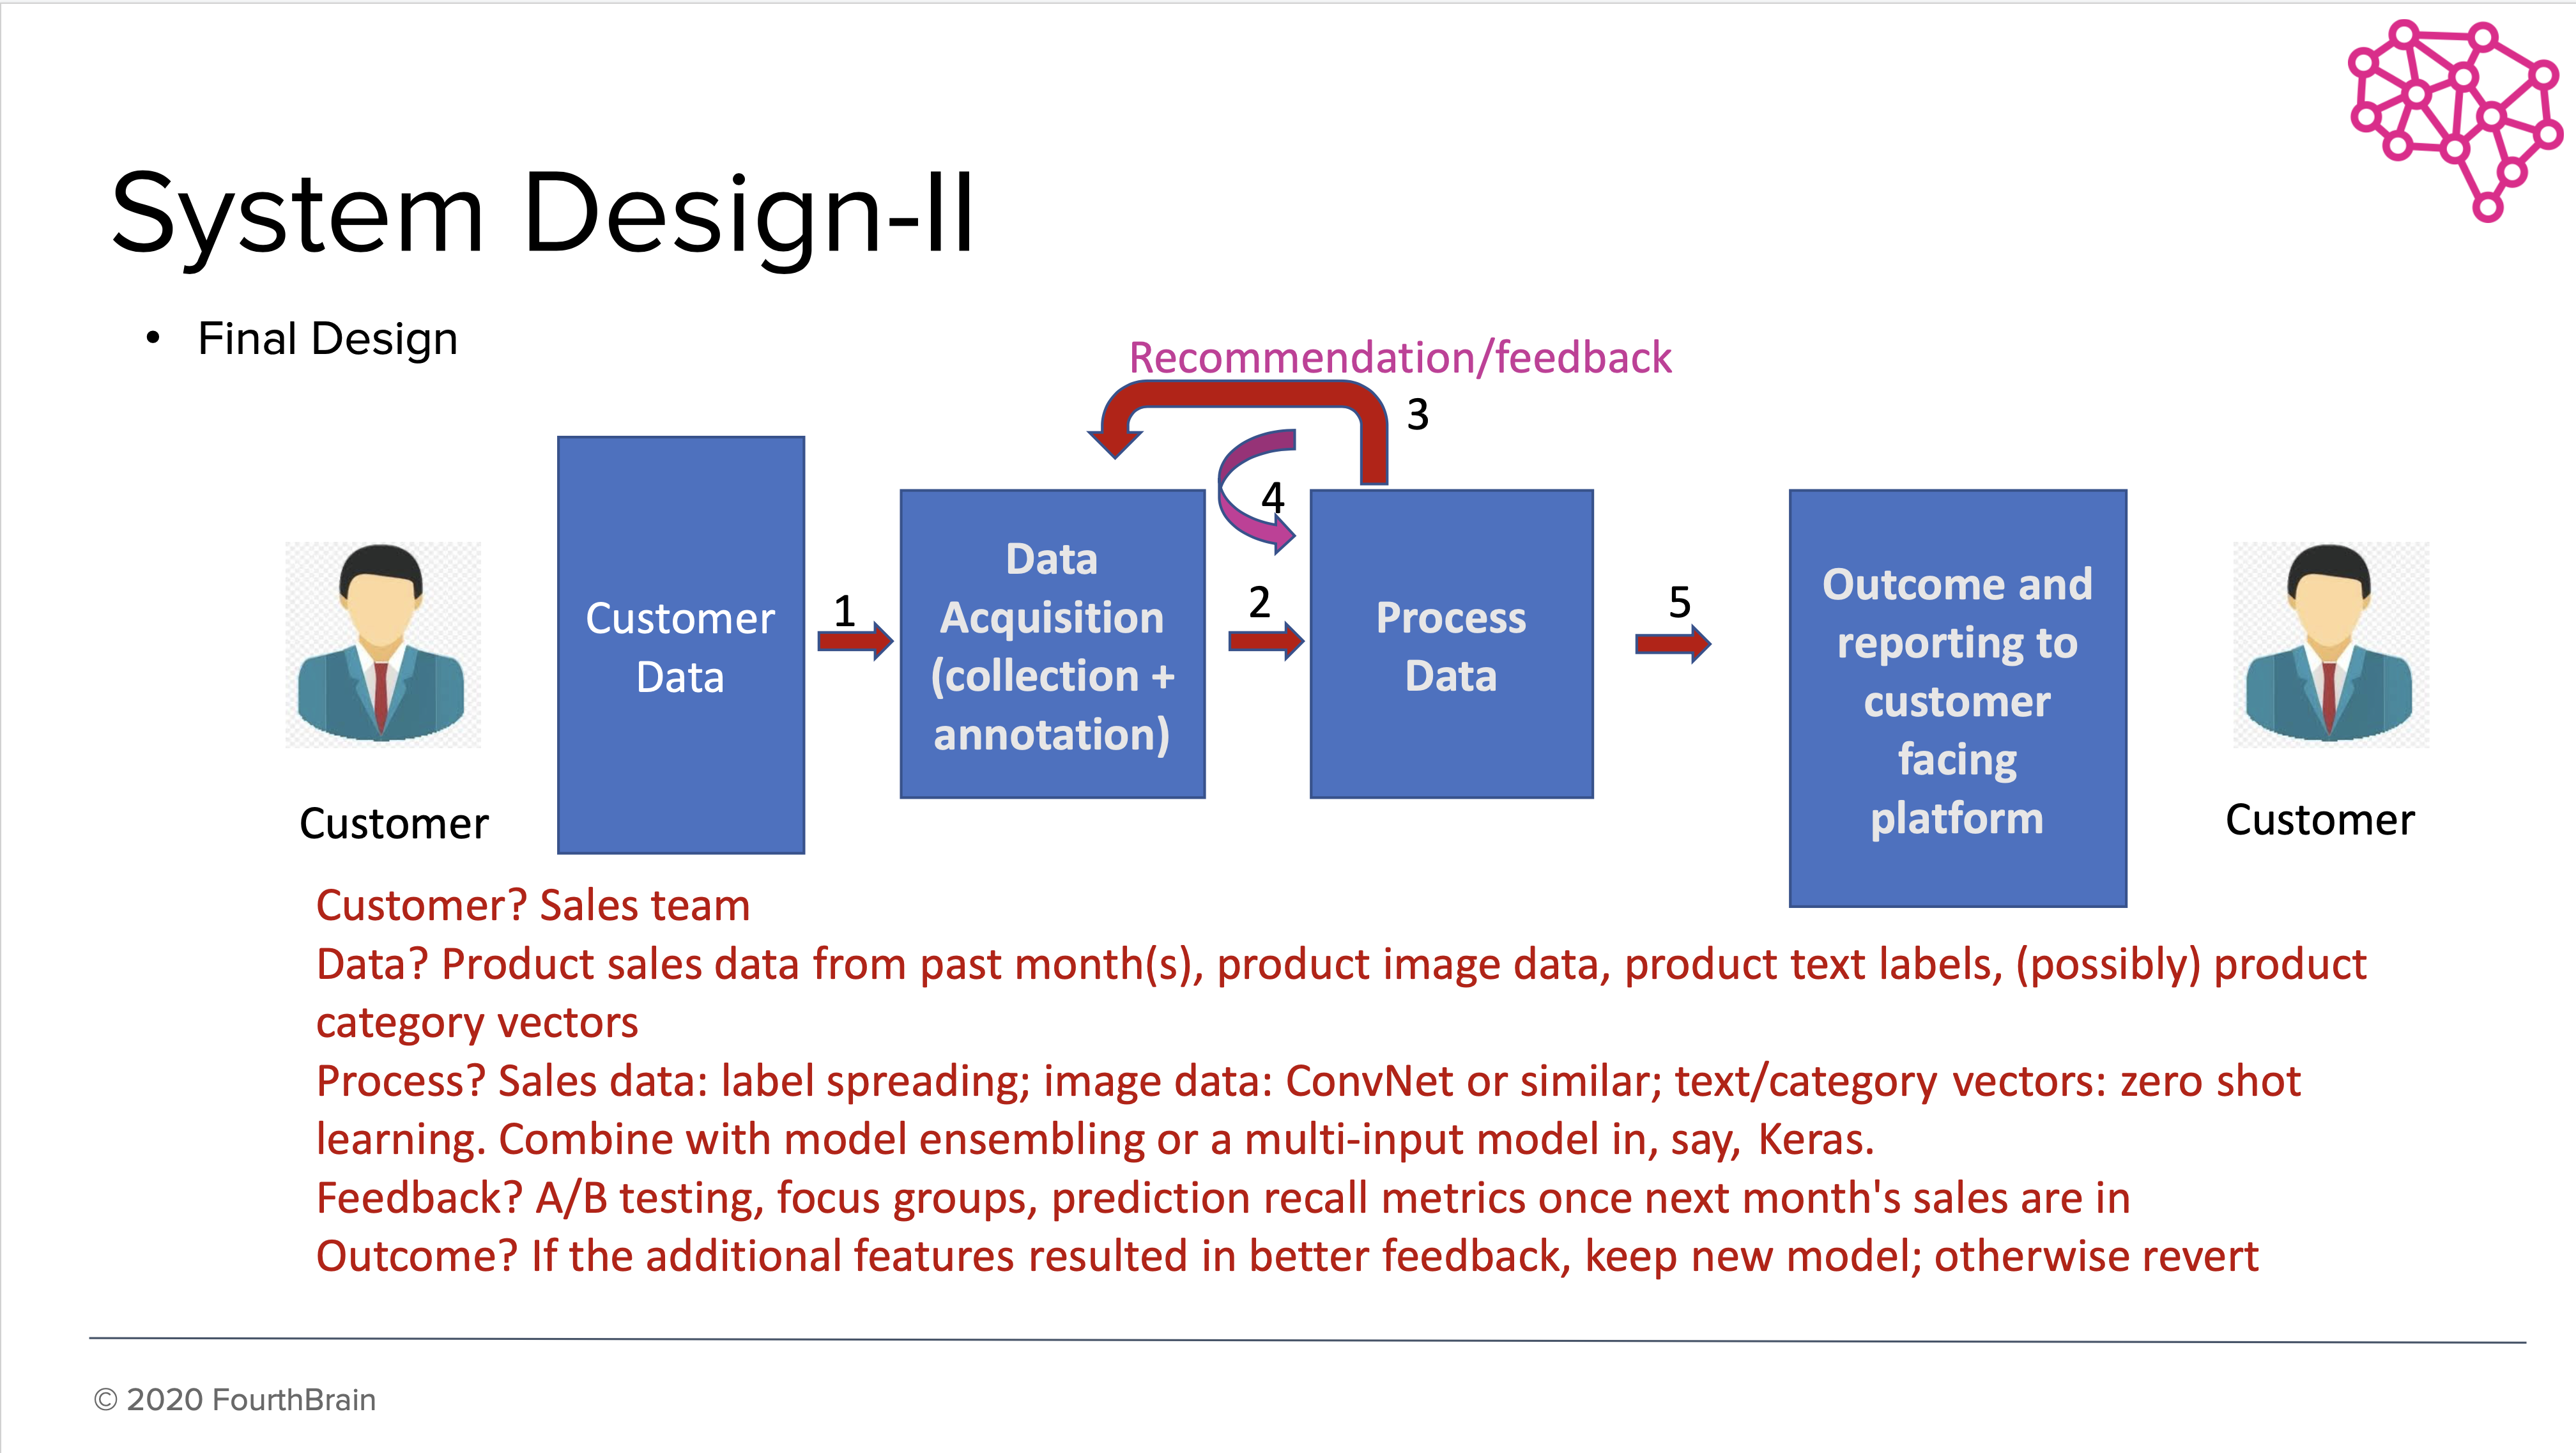

# Extra Credit

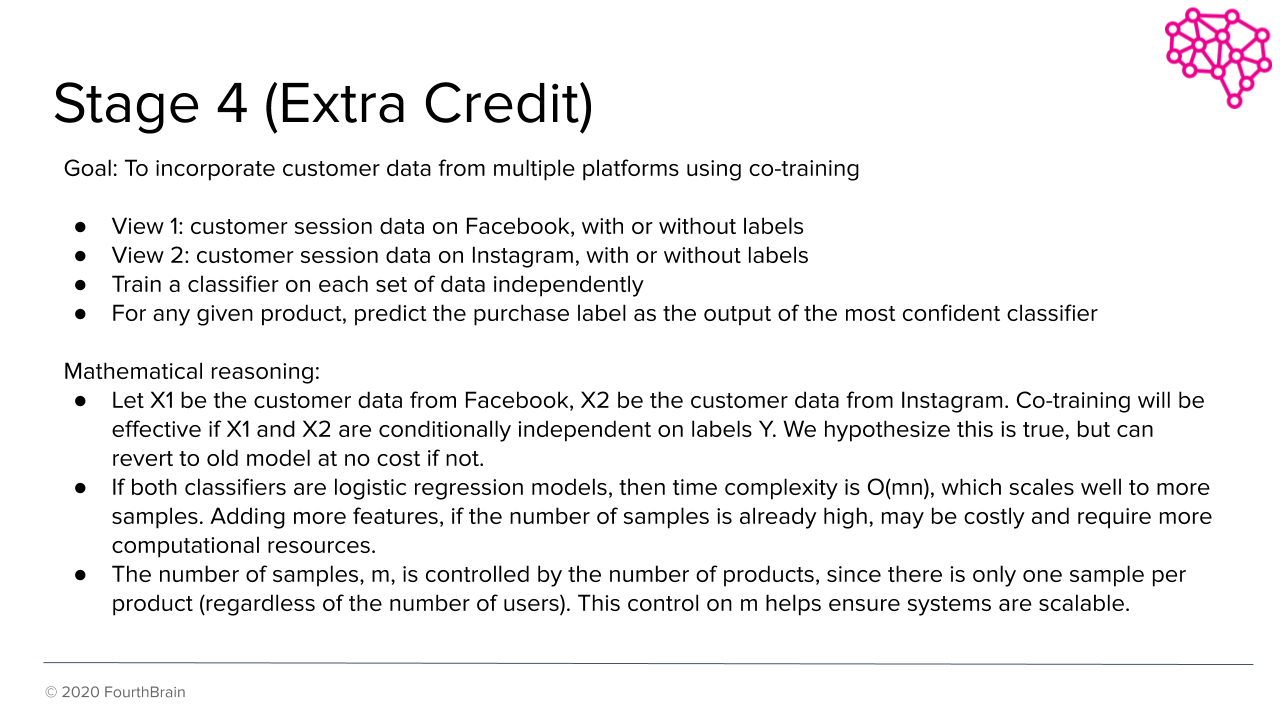

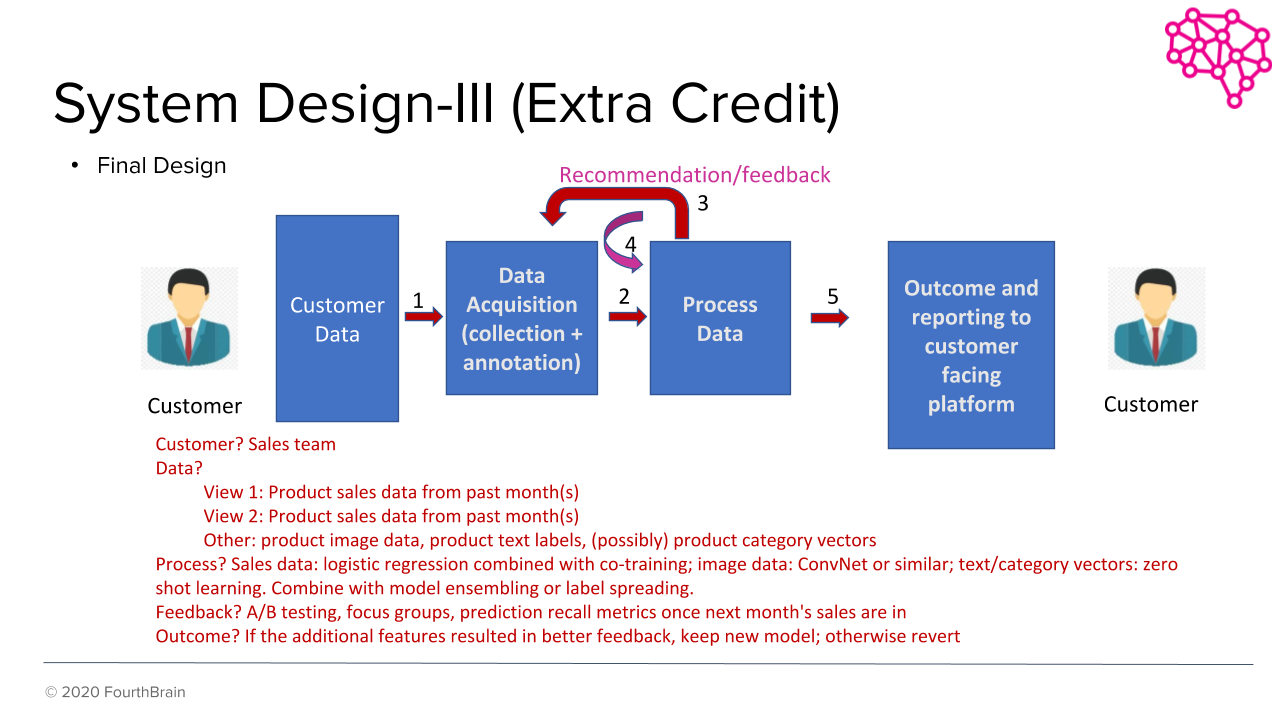

## Stage 4 Key Tasks
### 1. Customer data:
Customer sales data exists on multiple applications/sites. We plan to incorporate data from both Facebook and Instagram.
### 2. Data acquisition:
Ingest customer data from Facebook and Instagram, storing in two separate CSV/database files. These are the two "views" of the data. Data can be added statically at first, but if this system design adds value then data should be pulled and stored automatically.
### 3/4. Process data:
Sales data from Facebook and Instagram will be fed into their own independent classifiers, initially simple logistic regression models. The output of these models will be the predicted label (purchase/no purchase), which can be ensembled or otherwise incorporated into other features such as the image or text data. Finally, unlabeled data will be categorized using label spreading.
### 5. Outcome and reporting:
Given the feedback from A/B testing, focus groups, prediction statistics, etc., the Customer (i.e., the sales team) will decide whether the additional data from Facebook and Instagram provides a return on investment. If so, the new model is kept; if not, changes are rolled back.

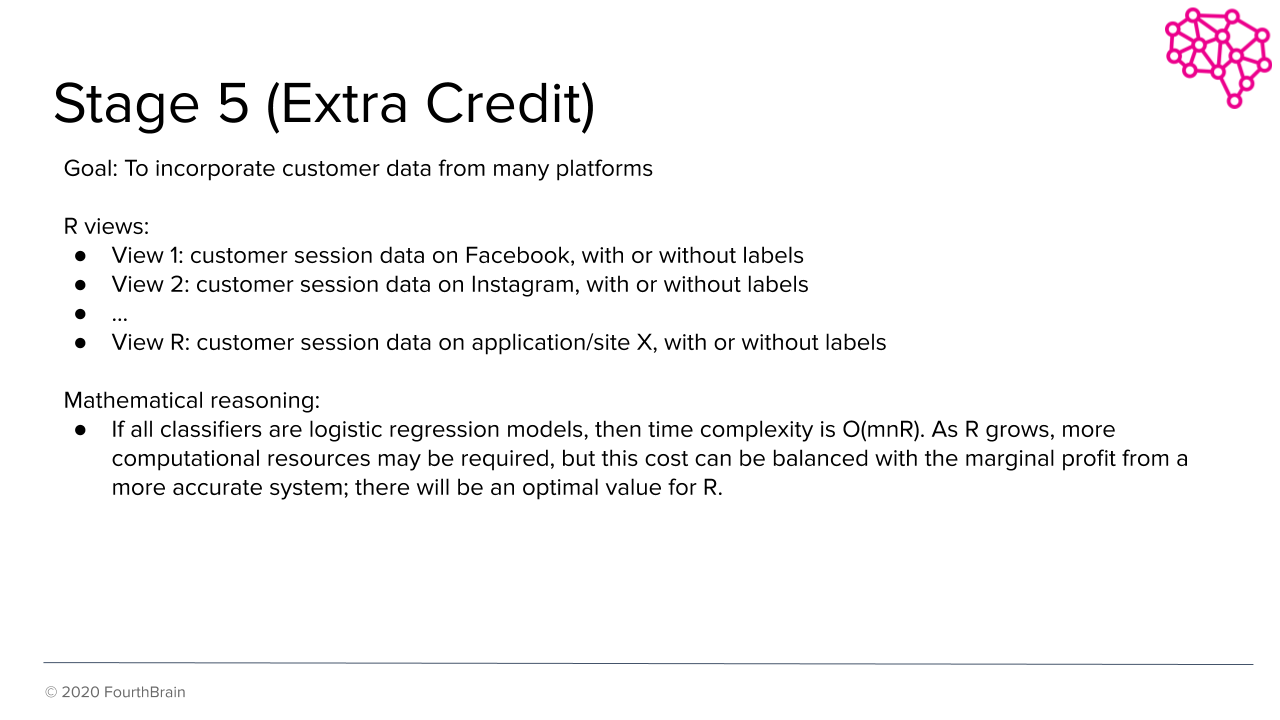

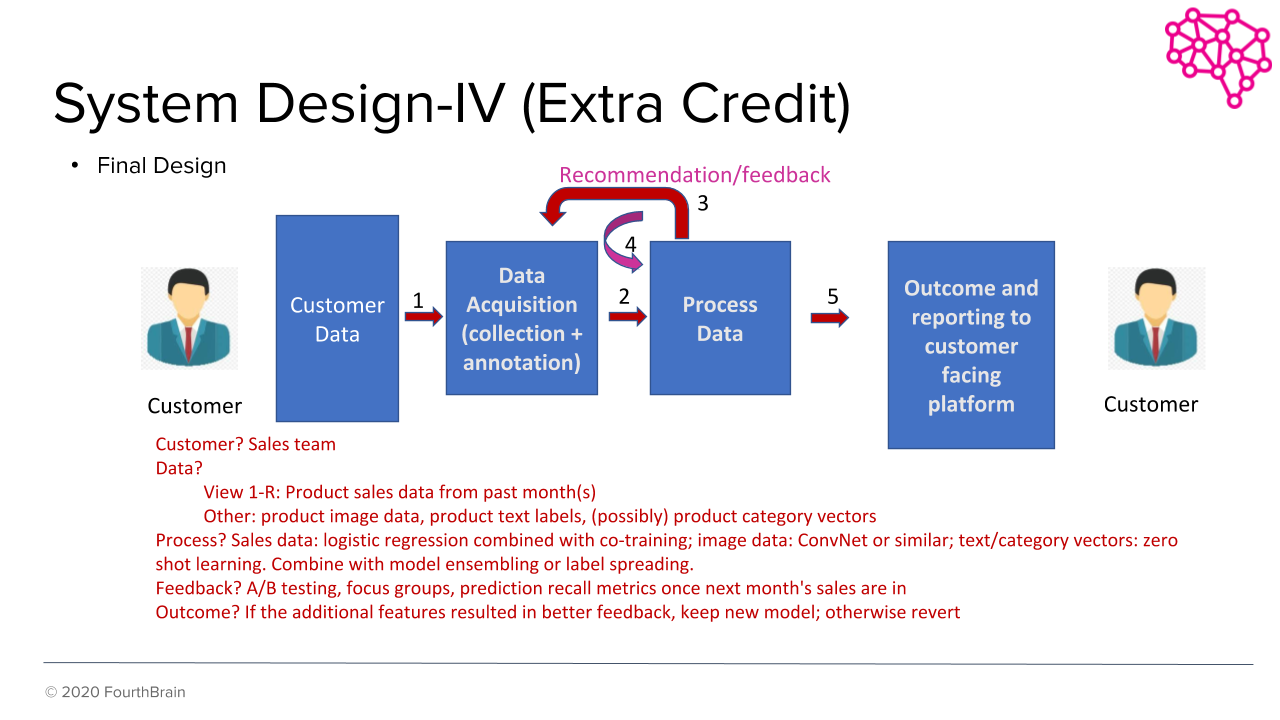

## Stage 5 Key Tasks
### 1. Customer data:
Customer sales data exists on multiple applications/sites. We plan to incorporate data from R independent sites.
### 2. Data acquisition:
Ingest customer data from R sites, storing in R separate CSV/database files. These are the R "views" of the data.
### 3/4. Process data:
Sales data from R sites will be fed into their own independent classifiers, initially simple logistic regression models. The classifiers will be combined just like the original Facebook and Instagram classifiers were.
### 5. Outcome and reporting:
No change to stage 4.